# Finding Best Neighbor for Delivery Business to Send DMs

### The Problem and The Background

An existing bicycle rental company in Manhattan, NYC is struggling tourists are now using Citi Bike, a privately owned public bicycle sharing system serving New York City. So the company decided to change its business from a rental bicycle to a delivery company for local people.

Luckily, they have enough employees to do the new business. However, the company is new in the delivery business, they need to run some ads. With a limited budget, they want to find out which neighbors (Zipcode) are the best to send DMs.
Their possible new customers are food-related businesses like restaurants and coffee shops, but the client doesn't want to deliver alcohol because it is time-consuming to check customers' ID.

### Data

1)Zip code
To send DMs, the data with zip code is easy to work with for the client. So I will use zip code data.
Data source: https://www.zipdatamaps.com/zipcodes-new-york-ny


2)Latitude and Longitude data
To work with Foursquare, I need latitude and longitude data.
Data source: https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/download/?format=csv&refine.state=NY&timezone=America/New_York&lang=en&use_labels_for_header=true&csv_separator=%3B

3)Venue Data
To see which type of food-related business is common in each area, I will use foursquare data.

4)Refference - Population Data
In Manhattan, each area is different. Some areas are mainly for business buildings. Other areas are mainly for residential buildings. So population data will be one of the good data to understand the area.
Data source: https://www.zipdatamaps.com/zipcodes-new-york-ny

### How to Solve the Problem
By using venue data from Foursquare, I will cluster neighbors (zipcode) by food related categories. The cliant can see what kind of food related businesses are in each cluster. If the area has food related businesses that are suitable for delivery, the cliant can decide to send DMs.

### Who would be interested in this project?
1. People who are looking for a new apartment in Manhattan
This data shows which venue is common in each area.

2. Restaurant Developpers
In Manhattan, restaurant business is very competitive. The developper can see what type of venue is common in each area.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


### Import Zip Code and Pupolation Data

In [2]:
url = "https://www.zipdatamaps.com/zipcodes-new-york-ny"
data = pd.read_html(url, header = 1)
df = data[0]
df.head()

,ZIP Code,ZIP Code Name,Population,Type
0,10001.0,New York,21102.0,Non-Unique
1,10002.0,New York,81410.0,Non-Unique
2,10003.0,New York,56024.0,Non-Unique
3,10004.0,New York,3089.0,Non-Unique
4,10005.0,New York,7135.0,Non-Unique


In [3]:
df = df.dropna(how='any')
df

,ZIP Code,ZIP Code Name,Population,Type
0,10001.0,New York,21102.0,Non-Unique
1,10002.0,New York,81410.0,Non-Unique
2,10003.0,New York,56024.0,Non-Unique
3,10004.0,New York,3089.0,Non-Unique
4,10005.0,New York,7135.0,Non-Unique
5,10006.0,New York,3011.0,Non-Unique
7,10007.0,New York,6988.0,Non-Unique
8,10009.0,New York,61347.0,Non-Unique
9,10010.0,New York,31834.0,Non-Unique
10,10011.0,New York,50984.0,Non-Unique


In [4]:
df.dtypes

ZIP Code         float64
ZIP Code Name     object
Population       float64
Type              object
dtype: object

In [5]:
df = df[['ZIP Code', 'Population']].astype('int')
df

,ZIP Code,Population
0,10001,21102
1,10002,81410
2,10003,56024
3,10004,3089
4,10005,7135
5,10006,3011
7,10007,6988
8,10009,61347
9,10010,31834
10,10011,50984


In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbff41495d0>]],
      dtype=object)

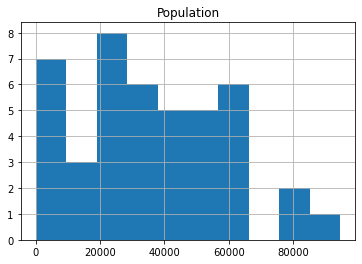

In [7]:
df_population = df.drop(['ZIP Code'], axis=1)
df_population.hist()

### Import Latitude and Longitude data

In [8]:
url2 = 'https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/download/?format=csv&refine.state=NY&timezone=America/New_York&lang=en&use_labels_for_header=true&csv_separator=%3B'
df2 = pd.read_csv(url2, sep = ';')
df2.head()

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,10940,Middletown,NY,41.449364,-74.43951,-5,1,"41.449364,-74.43951"
1,12930,Dickinson Center,NY,44.731571,-74.53485,-5,1,"44.731571,-74.53485"
2,14228,Buffalo,NY,43.023347,-78.79494,-5,1,"43.023347,-78.79494"
3,10706,Hastings On Hudson,NY,40.992084,-73.87290,-5,1,"40.992084,-73.8729"
4,13851,Vestal,NY,42.206745,-75.74488,-5,1,"42.206745,-75.74488"


In [9]:
df2.dtypes

Zip                             int64
City                           object
State                          object
Latitude                      float64
Longitude                     float64
Timezone                        int64
Daylight savings time flag      int64
geopoint                       object
dtype: object

In [10]:
df2 = df2.drop(['City', 'State', 'Timezone', 'Daylight savings time flag', 'geopoint'], axis=1)
df2.head()

,Zip,Latitude,Longitude
0,10940,41.449364,-74.43951
1,12930,44.731571,-74.53485
2,14228,43.023347,-78.79494
3,10706,40.992084,-73.87290
4,13851,42.206745,-75.74488


In [11]:
df2 = df2.rename(columns={'Zip': 'ZIP Code'})

In [12]:
df3 = pd.merge(df, df2, how="inner", on="ZIP Code")
df3

,ZIP Code,Population,Latitude,Longitude
0,10001,21102,40.750742,-73.99653
1,10002,81410,40.717040,-73.98700
2,10003,56024,40.732509,-73.98935
3,10005,7135,40.706019,-74.00858
4,10006,3011,40.707904,-74.01342
5,10007,6988,40.714754,-74.00721
6,10009,61347,40.727093,-73.97864
7,10010,31834,40.739022,-73.98205
8,10011,50984,40.741012,-74.00012
9,10012,24090,40.725960,-73.99834


### Import Foursquare Data

In [13]:
CLIENT_ID = '334O0IMZDUYFUP22KTK4AT1VXJE5S5SR00XJOTTRJLGQU3AB' # your Foursquare ID
CLIENT_SECRET = '2F5LB25JQZHQUSZERQUQHF1CXZODAFIDARVQ5YR1J332ZFHU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 334O0IMZDUYFUP22KTK4AT1VXJE5S5SR00XJOTTRJLGQU3AB
CLIENT_SECRET:2F5LB25JQZHQUSZERQUQHF1CXZODAFIDARVQ5YR1J332ZFHU


In [14]:
df3.loc[0, 'ZIP Code']

10001

In [15]:
neighborhood_latitude = df3.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df3.loc[0, 'Longitude'] # neighborhood longitude value
neighborhood_zip = df3.loc[0, 'ZIP Code'] # ZIP Code

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_zip, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of 10001 are 40.750741999999995, -73.99653.


### Get Venue Data from Foursquare
To extract only food related businesses, I put category ID (4d4b7105d754a06374d81259 = food)

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId=4d4b7105d754a06374d81259&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZIP Code', 
                  'ZIP Code Latitude', 
                  'ZIP Code Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [39]:
manhattan_venues = getNearbyVenues(names=df3['ZIP Code'],
                                   latitudes=df3['Latitude'],
                                   longitudes=df3['Longitude']
                                  )

10001
10002
10003
10005
10006
10007
10009
10010
10011
10012
10013
10014
10016
10017
10018
10019
10020
10021
10022
10023
10024
10025
10026
10027
10028
10029
10030
10031
10032
10033
10034
10035
10036
10037
10038
10039
10040
10044
10128
10280


### check the size of the resulting dataframe

In [40]:
print(manhattan_venues.shape)
manhattan_venues.head()

(2931, 7)


,ZIP Code,ZIP Code Latitude,ZIP Code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,10001,40.750742,-73.99653,New York Pizza Suprema,40.750124,-73.994992,Pizza Place
1,10001,40.750742,-73.99653,Panda Express,40.750301,-73.994707,Chinese Restaurant
2,10001,40.750742,-73.99653,Chirp,40.753377,-73.996116,Peruvian Restaurant
3,10001,40.750742,-73.99653,Magnolia Bakery,40.750963,-73.993576,Bakery
4,10001,40.750742,-73.99653,Salumeria Biellese Delicatessen,40.749081,-73.995606,Deli / Bodega


In [41]:
manhattan_venues.groupby('ZIP Code').count()

,ZIP Code Latitude,ZIP Code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
ZIP Code,,,,,,
10001,69,69,69,69,69,69
10002,100,100,100,100,100,100
10003,86,86,86,86,86,86
10005,100,100,100,100,100,100
10006,61,61,61,61,61,61
10007,81,81,81,81,81,81
10009,72,72,72,72,72,72
10010,76,76,76,76,76,76
10011,81,81,81,81,81,81


### Analyze Each Neighborhood

In [42]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['ZIP Code'] = manhattan_venues['ZIP Code'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,ZIP Code,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chaat Place,Chinese Restaurant,Churrascaria,Comfort Food Restaurant,Creperie,Cuban Restaurant,Czech Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hot Dog Joint,Hotpot Restaurant,Indian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Peking Duck Restaurant,Peruvian Restaurant,Pet Café,Pizza Place,Poke Place,Portuguese Restaurant,Puerto Rican Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Snack Place,Soba Restaurant,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
0,10001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,10001,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,10001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
manhattan_onehot.shape

(2931, 125)

In [25]:
manhattan_grouped = manhattan_onehot.groupby('ZIP Code').mean().reset_index()
manhattan_grouped

,ZIP Code,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chaat Place,Chinese Restaurant,Churrascaria,Comfort Food Restaurant,Creperie,Cuban Restaurant,Czech Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hot Dog Joint,Hotpot Restaurant,Indian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Peking Duck Restaurant,Peruvian Restaurant,Pet Café,Pizza Place,Poke Place,Portuguese Restaurant,Puerto Rican Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Snack Place,Soba Restaurant,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
0,10001,0.000000,0.014493,0.057971,0.000000,0.014493,0.000000,0.000000,0.00,0.000000,0.028986,0.028986,0.000000,0.000000,0.000000,0.028986,0.00,0.057971,0.000000,0.000000,0.072464,0.000000,0.000000,0.000000,0.000000,0.000000,0.028986,0.000000,0.000000,0.00,0.000000,0.000000,0.057971,0.000000,0.000000,0.014493,0.000000,0.000000,0.000000,0.000000,0.000000,0.028986,0.000000,0.000000,0.000000,0.028986,0.000000,0.000000,0.028986,0.000000,0.000000,0.000000,0.00,0.014493,0.000000,0.000000,0.000000,0.000000,0.000000,0.014493,0.000000,0.000000,0.028986,0.000000,0.014493,0.000000,0.000000,0.014493,0.000000,0.014493,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.028986,0.000000,0.043478,0.000000,0.000000,0.000000,0.014493,0.014493,0.00,0.072464,0.043478,0.000000,0.000000,0.000000,0.000000,0.014493,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.028986,0.028986,0.028986,0.000000,0.000000,0.014493,0.000000,0.014493,0.000000,0.043478,0.000000,0.000000,0.014493,0.00,0.000000,0.000000,0.00,0.000000,0.000000
1,10002,0.000000,0.000000,0.040000,0.000000,0.010000,0.070000,0.020000,0.01,0.000000,0.010000,0.050000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.050000,0.000000,0.010000,0.010000,0.000000,0.000000,0.040000,0.000000,0.000000,0.01,0.000000,0.000000,0.000000,0.010000,0.010000,0.010000,0.030000,0.000000,0.010000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.020000,0.000000,0.000000,0.030000,0.000000,0.000000,0.000000,0.00,0.010000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.030000,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.010000,0.020000,0.070000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.0

In [44]:
manhattan_grouped.shape

(40, 125)

In [45]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [86]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['ZIP Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['ZIP Code'] = manhattan_grouped['ZIP Code']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,ZIP Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,10001,Salad Place,Café,Burger Joint,Deli / Bodega,American Restaurant
1,10002,Mexican Restaurant,Asian Restaurant,Pizza Place,Bakery,Ramen Restaurant
2,10003,Japanese Restaurant,Mediterranean Restaurant,Pizza Place,Sushi Restaurant,Chinese Restaurant
3,10005,Salad Place,American Restaurant,Food Truck,Pizza Place,Mexican Restaurant
4,10006,Pizza Place,Mexican Restaurant,American Restaurant,Steakhouse,Café


### Cluster ZIP Code

In [87]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('ZIP Code', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 0, 2, 0, 2, 2, 2, 0], dtype=int32)

In [88]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels2', kmeans.labels_)

manhattan_merged = df3

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('ZIP Code'), on='ZIP Code')

manhattan_merged.head() # check the last columns!

,ZIP Code,Population,Latitude,Longitude,Cluster Labels2,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,10001,21102,40.750742,-73.99653,2,Salad Place,Café,Burger Joint,Deli / Bodega,American Restaurant
1,10002,81410,40.717040,-73.98700,2,Mexican Restaurant,Asian Restaurant,Pizza Place,Bakery,Ramen Restaurant
2,10003,56024,40.732509,-73.98935,2,Japanese Restaurant,Mediterranean Restaurant,Pizza Place,Sushi Restaurant,Chinese Restaurant
3,10005,7135,40.706019,-74.00858,0,Salad Place,American Restaurant,Food Truck,Pizza Place,Mexican Restaurant
4,10006,3011,40.707904,-74.01342,2,Pizza Place,Mexican Restaurant,American Restaurant,Steakhouse,Café


In [89]:
manhattan_merged.head()

,ZIP Code,Population,Latitude,Longitude,Cluster Labels2,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,10001,21102,40.750742,-73.99653,2,Salad Place,Café,Burger Joint,Deli / Bodega,American Restaurant
1,10002,81410,40.717040,-73.98700,2,Mexican Restaurant,Asian Restaurant,Pizza Place,Bakery,Ramen Restaurant
2,10003,56024,40.732509,-73.98935,2,Japanese Restaurant,Mediterranean Restaurant,Pizza Place,Sushi Restaurant,Chinese Restaurant
3,10005,7135,40.706019,-74.00858,0,Salad Place,American Restaurant,Food Truck,Pizza Place,Mexican Restaurant
4,10006,3011,40.707904,-74.01342,2,Pizza Place,Mexican Restaurant,American Restaurant,Steakhouse,Café


### Visualize the resulting clusters

In [72]:
!pip -q install folium

In [74]:
import folium

In [92]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [93]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['ZIP Code'], manhattan_merged['Cluster Labels2']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

* For map, please go see the report.
https://github.com/heather410/Coursera_Capstone/blob/master/Report.pdf

### Examine Clusters

Cluster 0 Red

Characteristics:
1. Mix of residential and business areas
2. Italian, American Restaurants

In [94]:
manhattan_merged.loc[manhattan_merged['Cluster Labels2'] == 0, manhattan_merged.columns[[0,1] + list(range(5, manhattan_merged.shape[1]))]]

,ZIP Code,Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,10005,7135,Salad Place,American Restaurant,Food Truck,Pizza Place,Mexican Restaurant
5,10007,6988,Sandwich Place,Italian Restaurant,Deli / Bodega,Food Truck,Sushi Restaurant
9,10012,24090,Italian Restaurant,Café,American Restaurant,Sushi Restaurant,French Restaurant
10,10013,27700,Italian Restaurant,American Restaurant,French Restaurant,Café,Deli / Bodega
11,10014,31959,Italian Restaurant,American Restaurant,New American Restaurant,Café,French Restaurant
16,10020,0,Steakhouse,Italian Restaurant,American Restaurant,French Restaurant,Sandwich Place
18,10022,31924,Italian Restaurant,French Restaurant,American Restaurant,Bakery,Steakhouse
19,10023,60998,Italian Restaurant,Café,Food Truck,Pizza Place,American Restaurant
20,10024,59283,Italian Restaurant,Café,Indian Restaurant,American Restaurant,Mediterranean Restaurant
23,10027,59707,Seafood Restaurant,Italian Restaurant,Chinese Restaurant,Deli / Bodega,Café


Cluster 1 Purple

Characteristics:
1. Harlem, Washington Hights, and Inwood area (residential)
2. Deli / Bodega, Mexican, Chainese restaurants

In [95]:
manhattan_merged.loc[manhattan_merged['Cluster Labels2'] == 1, manhattan_merged.columns[[0,1] + list(range(5, manhattan_merged.shape[1]))]]

,ZIP Code,Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
22,10026,34003,Deli / Bodega,African Restaurant,Caribbean Restaurant,Café,Seafood Restaurant
25,10029,76003,Deli / Bodega,Mexican Restaurant,Pizza Place,Thai Restaurant,Café
27,10031,56438,Deli / Bodega,Pizza Place,Mexican Restaurant,Chinese Restaurant,Caribbean Restaurant
28,10032,57331,Pizza Place,Bakery,Mexican Restaurant,Chinese Restaurant,Latin American Restaurant
29,10033,53926,Deli / Bodega,Bakery,Spanish Restaurant,Pizza Place,Chinese Restaurant
30,10034,38908,Restaurant,Deli / Bodega,Pizza Place,Mexican Restaurant,Café
31,10035,33969,Deli / Bodega,Pizza Place,Chinese Restaurant,American Restaurant,Fast Food Restaurant
33,10037,17416,Café,Latin American Restaurant,Southern / Soul Food Restaurant,Cafeteria,Burger Joint


Cluster 2 Blue

Characteristics:
1. Mix of residential and business areas
2. Mexican, Japanese, American, Italian restaurants

In [96]:
manhattan_merged.loc[manhattan_merged['Cluster Labels2'] == 2, manhattan_merged.columns[[0,1] + list(range(5, manhattan_merged.shape[1]))]]

,ZIP Code,Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,10001,21102,Salad Place,Café,Burger Joint,Deli / Bodega,American Restaurant
1,10002,81410,Mexican Restaurant,Asian Restaurant,Pizza Place,Bakery,Ramen Restaurant
2,10003,56024,Japanese Restaurant,Mediterranean Restaurant,Pizza Place,Sushi Restaurant,Chinese Restaurant
4,10006,3011,Pizza Place,Mexican Restaurant,American Restaurant,Steakhouse,Café
6,10009,61347,Mexican Restaurant,Pizza Place,Italian Restaurant,Korean Restaurant,Vegetarian / Vegan Restaurant
7,10010,31834,Indian Restaurant,Italian Restaurant,Bagel Shop,Pizza Place,American Restaurant
8,10011,50984,American Restaurant,Italian Restaurant,Sushi Restaurant,Bakery,Mexican Restaurant
12,10016,54183,Italian Restaurant,Mexican Restaurant,Deli / Bodega,Sandwich Place,Greek Restaurant
13,10017,16575,Japanese Restaurant,Italian Restaurant,Seafood Restaurant,Sushi Restaurant,Deli / Bodega
14,10018,5229,American Restaurant,Italian Restaurant,Pizza Place,Thai Restaurant,Sandwich Place


Cluster 3 Light Green

Characteristics:
1. Residential area
2. Deli / Bodega

In [97]:
manhattan_merged.loc[manhattan_merged['Cluster Labels2'] == 3, manhattan_merged.columns[[0,1] + list(range(5, manhattan_merged.shape[1]))]]

,ZIP Code,Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
26,10030,26999,Deli / Bodega,Southern / Soul Food Restaurant,Pizza Place,Chinese Restaurant,Sandwich Place
35,10039,24527,Deli / Bodega,Chinese Restaurant,Caribbean Restaurant,Indian Restaurant,Pizza Place
36,10040,41905,Deli / Bodega,Pizza Place,Chinese Restaurant,Seafood Restaurant,Donut Shop


Cluster 4 Orange

Characteristics:
1. Residential Area, but small population
2. Deli / Bodega

In [98]:
manhattan_merged.loc[manhattan_merged['Cluster Labels2'] == 4, manhattan_merged.columns[[0,1] + list(range(5, manhattan_merged.shape[1]))]]

,ZIP Code,Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
37,10044,11661,Deli / Bodega,Kosher Restaurant,Restaurant,Sandwich Place,Pizza Place


### Referrence: Population and the number of food related venues

In [79]:
df4 = manhattan_venues.groupby('ZIP Code').count()
df4

,ZIP Code Latitude,ZIP Code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
ZIP Code,,,,,,
10001,69,69,69,69,69,69
10002,100,100,100,100,100,100
10003,86,86,86,86,86,86
10005,100,100,100,100,100,100
10006,61,61,61,61,61,61
10007,81,81,81,81,81,81
10009,72,72,72,72,72,72
10010,76,76,76,76,76,76
10011,81,81,81,81,81,81


In [82]:
df5 = pd.merge(df, df4, how="inner", on="ZIP Code")
df5 = df5.drop(['ZIP Code Latitude','ZIP Code Longitude', 'Venue Latitude', 'Venue Longitude', 'Venue Category'], axis=1)
df5

,ZIP Code,Population,Venue
0,10001,21102,69
1,10002,81410,100
2,10003,56024,86
3,10005,7135,100
4,10006,3011,61
5,10007,6988,81
6,10009,61347,72
7,10010,31834,76
8,10011,50984,81
9,10012,24090,100


In [83]:
import seaborn as sns

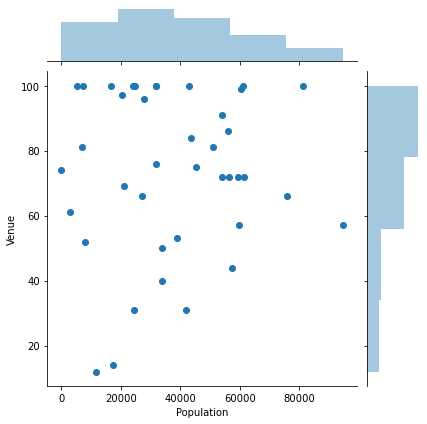

In [85]:
sns.jointplot(x="Population", y="Venue", data=df5)